# Model Output Notebook

<img style="float:center;" src="https://arcticexpansion.vse.gmu.edu/sites/arcticexpansion.vsnet.gmu.edu/files/images/header5d2.png" width=600px>

### ADCIRC-SWAN Output


### Initialize Libraries

In [1]:
import warnings;warnings.filterwarnings("ignore")
import netCDF4 as nc4;        import pandas as pd
import requests;              import json;
import matplotlib as mpl;     import matplotlib.pyplot as plt
import matplotlib.tri as tri; import pathlib as pl
import cartopy.crs as ccrs;   import cartopy.io.img_tiles as cart_img
import cartopy as cart;       import cartopy.io.img_tiles as cimgt
import numpy as np;           import xarray as xr
import skill_metrics as sm;   import geopandas as gpd
from shapely import Polygon,Point,MultiPoint,LineString,MultiLineString;import shapely.vectorized
from sklearn.neighbors import BallTree
from scipy.stats import linregress

source $HOME/miniforge3/bin/activate

salloc --ntasks=5 --nodes=1 --partition=normal --time=10:00:00

### Defined Functions

In [2]:
def noaa_data(begin,end,station,vdatum='NAVD',interval='6',
                       form='json',t_zone='GMT',unit='metric',product='water_level'):
    '''
    This function is used to get the data from NOAA API
    :param begin: begin date of the data
    :param end: end date of the data
    :param station: noaa station id
    :param vdatum: vertical datum such as NAVD
    :param interval: interval of the data (6 minutes)
    :param form: format of the data (json)
    :param t_zone: time zone of the data (GMT)
    :param unit: unit of the data (metric)
    :param product: type of the data (water_level)
    '''
    api = f'https://tidesandcurrents.noaa.gov/api/datagetter?begin_date={begin}&end_date={end}&station={station}'\
         f'&product={product}&application=NOS.COOPS.TAC.WL&datum={vdatum}&interval={interval}&time_zone={t_zone}&units={unit}&format={form}'
    data = requests.get(url=api).content.decode()
    return data


def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

def point_lookup(model_lat:np.array, model_lon:np.array, satellite_lat:np.array, satellite_lon:np.array):
    tree = BallTree(np.deg2rad(np.c_[model_lat,model_lon]), metric='haversine')
    distances, indices = tree.query(np.deg2rad(np.c_[satellite_lat, satellite_lon]), k = 1)
    return distances*6371,indices


#### Data for this exercise can be found here
https://doi.org/10.17603/ds2-h0fw-2p96

Download the swan_HS.63.nc from one of the 4 folders

---

In [3]:
root = pl.Path('/groups/ORC-CLIMATE/fhrl_repo/Arctic_Database')

In [7]:
files = list((root / '2024'/'outputs').glob('*.nc'))
years = ['2023','2022','2021','2020','2019',
         '2018','2017','2016','2015','2014','2013',
        '2012','2011','2010','2009','2008','2007','2006','2005']


In [8]:
for year in years:
    for file in files:
        if (root / year / 'outputs' / file.name).is_file():

            pass
        else:
            print(year +' ' + file.name)

2023 maxrs.63.nc
2019 fort.61.nc
2019 fort.62.nc
2019 fort.67.nc
2019 fort.68.nc
2018 fort.61.nc
2018 fort.62.nc
2018 fort.67.nc
2018 fort.68.nc
2018 fort.71.nc
2018 fort.72.nc
2018 fort.74.nc
2018 fort.91.nc
2017 maxrs.63.nc
2017 maxvel.63.nc
2017 maxwvel.63.nc
2016 fort.62.nc
2016 fort.67.nc
2016 fort.68.nc
2015 fort.61.nc
2015 fort.62.nc
2015 fort.67.nc
2015 fort.68.nc
2014 fort.61.nc
2014 fort.62.nc
2014 fort.67.nc
2014 fort.68.nc
2013 fort.61.nc
2013 fort.62.nc
2013 fort.67.nc
2013 fort.68.nc
2012 fort.62.nc
2012 fort.74.nc
2012 maxele.63.nc
2012 maxrs.63.nc
2012 maxvel.63.nc
2012 maxwvel.63.nc
2012 minpr.63.nc
2012 swan_DIR.63.nc
2012 swan_DIR_max.63.nc
2012 swan_HS.63.nc
2012 swan_HS_max.63.nc
2012 swan_TPS.63.nc
2012 swan_TPS_max.63.nc
2011 fort.62.nc
2010 fort.61.nc
2010 fort.62.nc
2010 fort.67.nc
2010 fort.68.nc
2009 fort.61.nc
2009 fort.62.nc
2009 fort.67.nc
2009 fort.68.nc
2007 fort.61.nc
2007 fort.62.nc
2007 fort.63.nc
2007 fort.64.nc
2007 fort.67.nc
2007 fort.68.nc
2007 f

In [7]:
stations = {'prudhoe':{'id':9497645,'lat':70.421459,'lon':-148.546311},
            'red':{'id':9491094,'lat':67.573681,'lon':-164.070663},
            'nome':{'id':9468756,'lat':64.499170,'lon':-165.431689},
            'unalakleet':{'id':9468333,'lat':63.881322,'lon':-160.820145},
            'paul':{'id':9464212,'lat':57.228635,'lon':-170.241801}}
resample_time = 'D'
years = ['2024','2023','2022','2021','2020','2019',
         '2018','2017','2016','2015','2014','2013',
        '2012','2011','2010']
name = 'red'

obs_lat = stations[name]['lat']
obs_lon = stations[name]['lon']
df_list,df_hourly_list = [],[]
for year in years:
    ncfile = nc4.Dataset(root / year /'outputs' / 'fort.63.nc')
    start = pd.to_datetime(ncfile.variables['time'].base_date)
    dt = pd.date_range(start=start,freq='1h',periods=ncfile.dimensions['time'].size)
    x,y = ncfile.variables['x'][:],ncfile.variables['y'][:]
    distances,node_ids = point_lookup(y, x,obs_lat,obs_lon)
    model = ncfile.variables['zeta'][:,node_ids[0][0]]
    df = pd.DataFrame({'dt': dt, 'data': model})
    df_daily_max = df.resample(resample_time, on='dt').max().reset_index()
    df_daily_max["Year"] = df_daily_max["dt"].dt.year
    df["Year"] = df["dt"].dt.year  # Add year column
    df_list.append(df_daily_max)
    df_hourly_list.append(df)

df_daily_wse = pd.concat(df_list, ignore_index=True)
df_daily_wse = df_daily_wse.iloc[1:].reset_index(drop=True)
df_annual_max = df_daily_wse.groupby("Year")["data"].max().reset_index()
slope_annual, intercept_annual, r_value, p_value, std_err = linregress(df_annual_max["Year"], df_annual_max["data"])
df_annual_max["Expected_WSE"] = df_annual_max["Year"] * slope_annual + intercept_annual
df_daily_wse["Year"] = df_daily_wse["dt"].dt.year
df_daily_wse["Month"] = df_daily_wse["dt"].dt.month
df_hourly_wse = pd.concat(df_hourly_list, ignore_index=True)
df_hourly_wse.to_csv(f'/scratch/tmiesse/project/model_data/{name}_model_hourly_wse.csv')

### Initialize path and read netcdf file

In [3]:
root = pl.Path('/groups/ORC-CLIMATE/fhrl_repo/Arctic_Database')

ncfile = nc4.Dataset(root / '2024' /'outputs' / 'fort.63.nc')

#### Read metadata within netcdf file

In [ ]:
start = pd.to_datetime(ncfile.variables['time'].base_date)
dt = pd.date_range(start=start,freq='1h',periods=ncfile.dimensions['time'].size)

# read the lons and lats from netcdf file
x,y = ncfile.variables['x'][:],ncfile.variables['y'][:]

_____________________________________

In [5]:
stations = {'prudhoe':{'id':9497645,'lat':70.401494,'lon':-148.544782},
            'red':{'id':9491094,'lat':67.573874,'lon':-164.066624},
            'nome':{'id':9468756,'lat':64.486464,'lon':-165.450185},
            'unalakleet':{'id':9468333,'lat':63.881322,'lon':-160.820145},
            'paul':{'id':9464212,'lat':57.228635,'lon':-170.241801}}

In [6]:
name = 'nome'
station = stations[name]['id']
start,end = pd.to_datetime('2022-01-01 01:00').strftime('%Y%m%d %H:%M'),dt[-1].strftime('%Y%m%d %H:%M')#pd.to_datetime('2019-01-01 01:00').strftime('%Y%m%d %H:%M')
file = json.loads(noaa_data(start,end,station,vdatum='MSL',interval='6',product='hourly_height'))

obs =np.array([float(file['data'][i]['v']) if file['data'][i]['v']!='' else np.nan for i in range(len(file['data']))])
obs_dt = pd.to_datetime([file['data'][i]['t'] for i in range(len(file['data']))])

KeyboardInterrupt: 

In [27]:
file = pd.read_csv(f'/scratch/tmiesse/project/noaa_data/{name}_noaa.csv')
obs = file['obs'].values
obs_dt=file['time']

In [14]:
# search for the nearest model node to the location inputted
obs_lat = 66.257636#stations[name]['lat']
obs_lon = -166.090238#stations[name]['lon']
distances,node_ids = point_lookup(y, x,obs_lat,obs_lon)
#taylor1 = sm.taylor_statistics(ncfile.variables['zeta'][:,node_ids[0][0]],obs)

##### plot timeseries of the Hs 

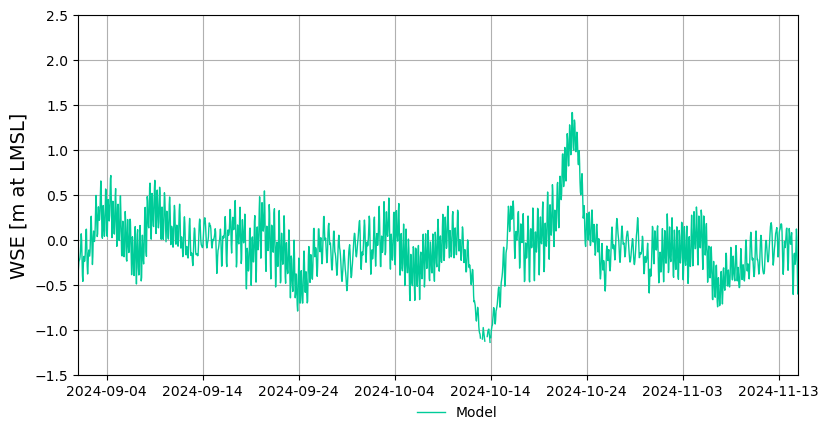

In [15]:
# plot parameters to initialize the plot
#plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize=(8,4))
colors = ['#00cc99','#ffcc66','#99cc00']
ax = plt.axes([0,0.,0.9,.9])
c=0


model = ncfile.variables['zeta'][:,node_ids[0][0]]
ax.plot(dt[:],model,color=colors[c],label='Model',linewidth=1)

#ax.plot(pd.to_datetime(obs_dt),obs,color='#7094db',label='NOAA',linewidth=1)

#bbox = dict(boxstyle='round', fc='white', ec='black', alpha=0.5)
#bias = np.nanmean(obs - model)
#text = (f'Bias = {bias:.2f} m \n'
#        f'RMSE = {taylor1["crmsd"][1]:.2f} m')

#ax.text(0.975,0.875,text,fontsize=12,transform=ax.transAxes, horizontalalignment='right',bbox=bbox)

#ax.plot(dt_int,bias,color='#8c8c8c',linestyle='--',label='Bias',linewidth=2)

ax.set_ylabel(r'WSE [m at LMSL]',fontsize=14)
ax.set_ylim([-1.500001,2.500001])
dt1 = pd.to_datetime('2024-09-01')
dt2 = pd.to_datetime('2024-11-15')
ax.set_xlim([dt1,dt2])
ax.grid(True)
ax.legend(loc='upper right', bbox_to_anchor=(0.6, -.05),ncol=2,frameon=False,fontsize=10)
#ax.set_title(name)
ax.xaxis.set_major_locator(plt.MaxNLocator(8))
#plt.savefig(f'/Users/tmiesse/work/FHRL/arctic/model/arctic_ocean_coastal_study/figures/{name}_wl.png',dpi=480,bbox_inches='tight',pad_inches=0.1,transparent=True)
plt.show()

In [13]:
dt1 = pd.to_datetime('2022-08-29')
dt2 = pd.to_datetime('2022-9-29')
t_id = np.where((dt1<dt.values)&(dt.values<dt2))[0]

In [17]:
ncfile = nc4.Dataset(root / '2022' /'outputs' / 'fort.74.nc')
u,v = ncfile.variables['windx'][t_id,node_ids[0][0]],ncfile.variables['windy'][t_id,node_ids[0][0]]
mag = np.sqrt(u**2 + v**2)
ncfile = nc4.Dataset(root / '2022' /'outputs' / 'fort.73.nc')
pressure = ncfile.variables['pressure'][t_id,node_ids[0][0]]
ncfile.close()

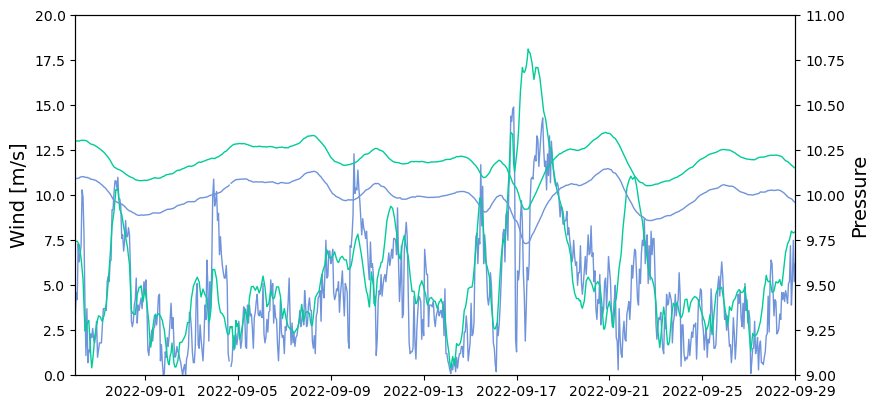

In [24]:
fig = plt.figure(figsize=(8,4))
colors = ['#00cc99','#ffcc66','#99cc00']
ax = plt.axes([0,0.,0.9,.9])

file = pd.read_csv(f'/scratch/tmiesse/project/noaa_data/wind22.csv')
obs = file['obs'].values
obs_dt=file['date']
ax.plot(pd.to_datetime(obs_dt),obs,color='#7094db',label='NOAA',linewidth=1)
ax.plot(dt[t_id],mag,color=colors[c],label='Model',linewidth=1)


ax2 = ax.twinx()
file = pd.read_csv(f'/scratch/tmiesse/project/noaa_data/pressure22.csv')
obs = file['obs'].values/100
obs_dt=file['date']
ax2.plot(pd.to_datetime(obs_dt),obs,color='#7094db',label='NOAA',linewidth=1)
ax2.plot(dt[t_id],pressure,color=colors[c],label='Model',linewidth=1)


ax.set_ylabel(r'Wind [m/s]',fontsize=14)
ax2.set_ylabel(r'Pressure',fontsize=14)
ax.set_ylim([0,20])
ax2.set_ylim([9,11])
ax.set_xlim([dt1,dt2])
ax.xaxis.set_major_locator(plt.MaxNLocator(8))
plt.show()

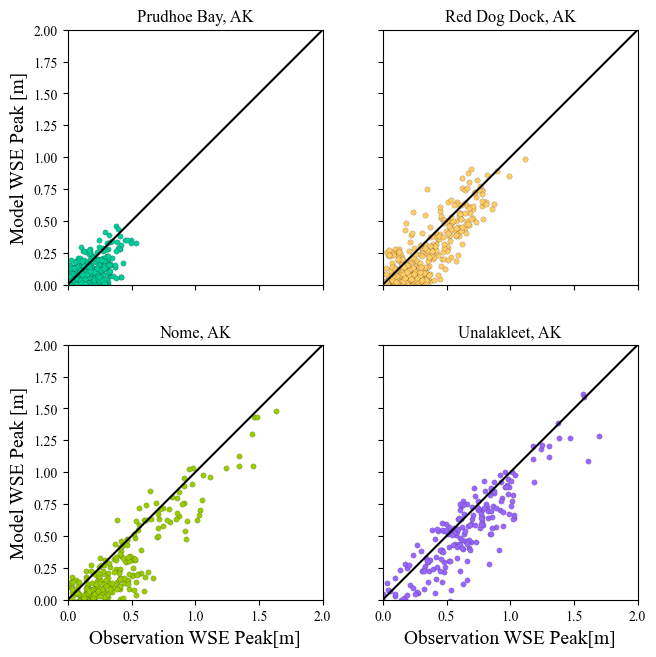

In [ ]:
#plt.rcParams["font.family"] = "Times New Roman"
colors = ['#00cc99','#ffcc66','#99cc00','#9966ff','#cc9900','#009999']
fig = plt.figure(figsize=(6,6))
ax = [plt.axes([0.0,0.525,0.425,0.425]),plt.axes([0.525,0.525,0.425,0.425]),
      plt.axes([0.0,0.0,0.425,0.425]),plt.axes([0.525,0.0,0.425,0.425])]
c=0
for s in list(stations.keys())[:4]:
      station = stations[s]['id']
      file = json.loads(noaa_data(start,end,station,vdatum='MSL',interval='6',product='hourly_height'))
      obs =np.array([float(file['data'][i]['v']) if file['data'][i]['v']!='' else np.nan for i in range(len(file['data']))])
      obs_lat = stations[s]['lat']
      obs_lon = stations[s]['lon']
      distances,node_ids = point_lookup(y, x,obs_lat,obs_lon)
      model = ncfile.variables['zeta'][:,node_ids[0][0]]
      dt2m = pd.date_range(start=start,end=end,freq='1h')
      mod_in=np.interp(dt2m,dt,model)
      obs_in= np.interp(dt2m,obs_dt,obs)
      slope = np.diff(mod_in,prepend=np.nan)
      idm = np.where((slope[:-1] > 0) & (slope[1:] < 0))[0]
      #idm #= np.where(model[sign_change_indices]>0)[0]
      ax[c].scatter(obs_in[idm],mod_in[idm],color=colors[c],s=15,edgecolors='k',linewidth=0.1)
      
      ax[c].set_ylim([-.000001,2.000001])
      ax[c].set_xlim([0,2.00001])
      ax[c].plot([0,15],[0,15],'k')
      c+=1
for i in range(len(ax)):
    if (i==0) or (i==2):
        ax[i].set_ylabel(r'Model WSE Peak [m]',fontsize=14)
    else:
        ax[i].set_yticklabels(['','','','','',''])
    if (i==2) or (i==3):
        ax[i].set_xlabel(r'Observation WSE Peak[m]',fontsize=14)
    else:
        ax[i].set_xticklabels(['','','','','',''])
ax[0].set_title('Prudhoe Bay, AK'),ax[1].set_title('Red Dog Dock, AK')
ax[2].set_title('Nome, AK'),ax[3].set_title('Unalakleet, AK')
plt.savefig(f'/Users/tmiesse/work/FHRL/arctic/model/arctic_ocean_coastal_study/figures/wl_metric.png',dpi=480,bbox_inches='tight',pad_inches=0.1,transparent=True)
plt.show()


#### plot a map of the Hs at a specific time

In [37]:
shp_paths = pl.Path('/groups/ORC-CLIMATE/fhrl_repo/Arctic_Database/arctic_shapefiles')
communities = gpd.read_file(shp_paths / 'communities' /'City_Boundaries_wgs84.shp')
county = gpd.read_file(shp_paths / 'Alaska_Borough_and_Census_Area_Boundaries' /'Alaska_Borough_and_Census_Area_Boundaries.shp')
coastline = gpd.read_file(shp_paths / 'Alaska_Coastline' /'Alaska_Coastline.shp')

In [90]:
# map boundary ------------------------------------------------------------------------
lat1,lat2 = 66,66.5
lon1,lon2 = -169, -164.5

# defining the time range I want
time1, time2 = np.datetime64('2024-10-11 21:00:00'),np.datetime64('2024-10-25 23:00:00')
# search for the nearest time to the time inputted
idx = np.where((time1 < dt.values) &\
               (dt.values < time2))[0]

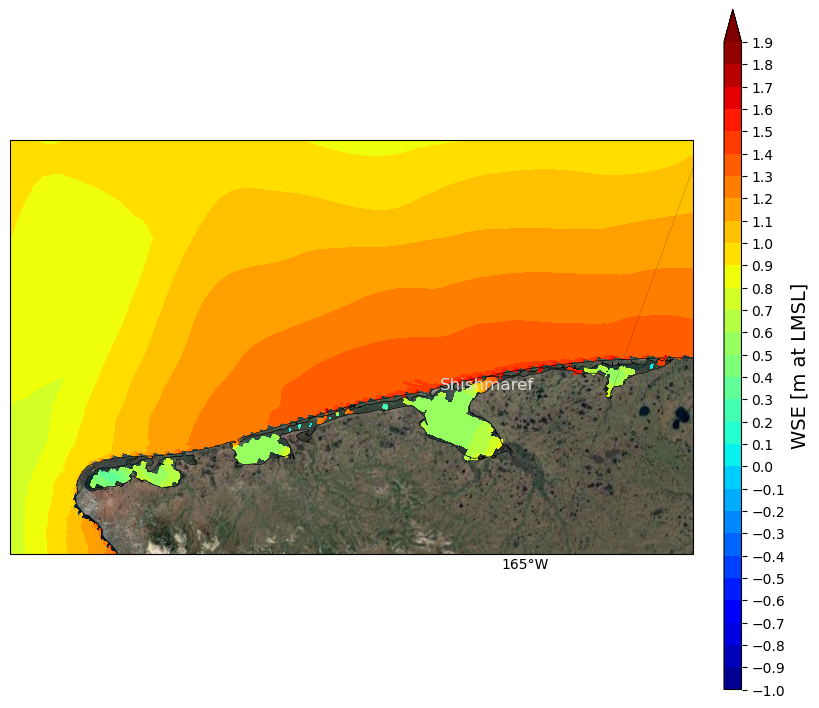

In [91]:
# plot parameters to initialize the plot
proj = ccrs.NorthPolarStereo(central_longitude=-145) # this data is in the arctic so we use the NorthPolarStereo projection
google_terrain = cimgt.GoogleTiles(style="satellite")
#proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(7,10))    
ax = plt.axes([0,0.,0.975,.975],projection=proj)
cmap = mpl.cm.get_cmap('jet')

# define countorus levels and colormap
levels = np.arange(-1.,2.,0.1)


# plot the model data on a map
# this is a triangular grid so we need to define the triangles
# and we need to use tricontourf to plot the data
triang = tri.Triangulation(x,y, triangles=ncfile.variables['element'][:,:]-1)
Z = np.max(ncfile['zeta'][idx,:],axis=0)
if Z.mask.any():
    point_mask_indices = np.where(Z.mask)
    tri_mask = np.any(np.in1d(ncfile.variables['element'][:,:]-1 , \
                              point_mask_indices).reshape(-1, 3), axis=1)
    triang.set_mask(tri_mask)
cf = ax.tricontourf(triang, Z,transform = ccrs.PlateCarree(),levels=levels, extend = 'max',cmap = cmap)

#Z = ncfile2['iceaf'][idx,:].data
#ice_level1 = [0,20,40,60,80,100]
#ice_level2 = np.arange(0.0,100.00000000,20)
#cf1 = ax.tricontour(triang, Z,transform = ccrs.PlateCarree(),levels=ice_level2,
#                            extend='max',cmap=mpl.cm.get_cmap('gist_gray'), linewidths = 1,zorder=2)#colors = '#f2f2f2'
# map parameters to make it look nice 

for c in range(len(communities)):
    cx,cy = communities.iloc[c].geometry.centroid.x,communities.iloc[c].geometry.centroid.y
    cname = communities.iloc[c]['CommunityN']
    if shapely.vectorized.contains(Polygon([(lon1,lat1),(lon1,lat2),(lon2,lat2),(lon2,lat1)]),cx,cy)==True:
        ax.text(cx,cy,cname,fontsize=12,transform=ccrs.PlateCarree(),color='#d9d9d9')
for c in range(len(coastline)):
    cx,cy = coastline.iloc[c].geometry.exterior.xy
    ax.plot(cx,cy,transform=ccrs.PlateCarree(),color='black',linewidth=0.5)
ax.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax.add_image(google_terrain, 8)
#ax.coastlines(resolution='10m',linewidth=0.5)
ax.add_feature(cart.feature.RIVERS,linestyle="-")
ax.add_feature(cart.feature.BORDERS.with_scale("50m"),linestyle="-")
gl = ax.gridlines(xlocs=np.arange(-190,-100,5),ylocs=np.arange(-90,90,3.5),
                            draw_labels=True,linewidth=0.3, color="black", alpha=0.5,
                            y_inline=False,linestyle="--",zorder=20)
gl.xlabels_top = False
gl.xlabels_bottom = True
gl.xlabel_style = {'rotation': 0}
gl.ylabels_left = False
gl.ylabels_right= True
gl.ylabel_style = {'rotation': -90}
gl.ypadding = 1.25
gl.xformatter = cart.mpl.gridliner.LONGITUDE_FORMATTER
gl.xpadding = 8

# add the colorbar
cbar_ax = fig.add_axes([1.02,.145,0.025,0.68])
cbar = fig.colorbar(cf,cax = cbar_ax, ticks=levels,orientation='vertical')
cbar.set_label(label = r'WSE [m at LMSL]',fontsize =14)
#cbar_ax2 = fig.add_axes([0.,-0.075,0.97,0.02])
#cbar = mpl.colorbar.ColorbarBase(cbar_ax2, cmap=mpl.cm.get_cmap('gist_gray'), values=ice_level2,
#                                    ticks=ice_level1,orientation='horizontal')

#cbar.set_label(label = r'Sea Ice Concentration [0-1]',fontsize =12,labelpad=-0.1)

plt.show()

In [ ]:
def fmt(x):
    s = f"{x:.1f}"
    s = f"{x:.0f}"
    return rf"{s} \%" if plt.rcParams["text.usetex"] else f"{s} %"
def omitcontours(cf):
    for level in cf.collections:
        for kp,path in reversed(list(enumerate(level.get_paths()))):
            # go in reversed order due to deletions!
            # include test for "smallness" of your choice here:
            # I'm using a simple estimation for the diameter based on the
            #    x and y diameter...
            verts = path.vertices # (N,2)-shape array of contour line coordinates
            diameter = np.max(verts.max(axis=0) - verts.min(axis=0))
            if diameter<2: # threshold to be refined for your actual dimensions!
                del(level.get_paths()[kp])  # no remove() for Path objects:(
    return

In [18]:
shapely.vectorized.contains(Polygon([(lon1,lat1),(lon1,lat2),(lon2,lat2),(lon2,lat2)]),cx,cy)#==True

np.False_